----------------

# Task 3.1.2

**Data Loader**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import math

def load_data(batch_size=128):
    """Load CIFAR-100 dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader

**Teacher Model**

In [2]:
class TeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        model.classifier[-1] = nn.Linear(4096, 100)
        self.classifier = model.classifier
        
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[-1].parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
model = TeacherModel()
load_state = model.state_dict()

for k, v in load_state.items():
    print(k)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 210MB/s]  


features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


**Student Model**

In [3]:
import torch
import torch.nn as nn
from torchvision import models

class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained VGG11 with proper weights
        weights = models.VGG11_Weights.IMAGENET1K_V1  # Proper way to specify pretrained weights
        model = models.vgg11(weights=weights)
        
        # Keep the pretrained features
        self.features = model.features
        
        # Modify the classifier for 100 classes while keeping pretrained weights
        # Get the existing classifier except last layer
        classifier_layers = list(model.classifier.children())[:-1]
        # Add new last layer for 100 classes
        classifier_layers.append(nn.Linear(4096, 100))
        self.classifier = nn.Sequential(*classifier_layers)
        
        # Initialize only the new last layer
        nn.init.normal_(self.classifier[-1].weight, 0, 0.01)
        nn.init.constant_(self.classifier[-1].bias, 0)
    
    def _init_weights(self, m):  # Fixed method name
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

**Teacher Finetuning**

In [4]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

def train_model(model, trainloader, testloader, device, epochs=7, model_name="model"):
    """Train a model (teacher or student) on CIFAR-100 using Adam optimizer."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with tqdm
        train_loader_tqdm = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs} - Training {model_name}")
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update tqdm bar with the current loss and accuracy
            train_loader_tqdm.set_postfix(loss=running_loss / (total or 1), accuracy=100. * correct / (total or 1))
        
        # Print epoch-level metrics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        print(f"{model_name.capitalize()} Training: Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%")
        
        # Evaluation loop with tqdm
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            val_loader_tqdm = tqdm(testloader, desc=f"Epoch {epoch + 1}/{epochs} - Validating {model_name}")
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100. * correct / total
        print(f"{model_name.capitalize()} Epoch {epoch + 1}: Validation Accuracy: {acc:.2f}%")
        
        # Save the best model based on validation accuracy
        if acc > best_acc:
            best_acc = acc
            save_path = f'best_{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Model saved as {save_path} with accuracy: {acc:.2f}%')
        
        scheduler.step()
    
    # Load the best model
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    return model


In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the data
trainloader, testloader = load_data()

# Train the teacher model with specified epochs
print("Initializing and training teacher model...")
teacher_model = TeacherModel().to(device)
trained_teacher = train_model(teacher_model, trainloader, testloader, device, epochs=7, model_name="teacher")

# Save both models as ZIP files
torch.save(trained_teacher.state_dict(), 'best_teacher.pth')
!zip -r teacher_model.zip best_teacher.pth


Using device: cuda


100%|██████████| 169001437/169001437 [00:03<00:00, 49387426.01it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Initializing and training teacher model...


Epoch 1/7 - Training teacher: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, accuracy=31.5, loss=0.0246]


Teacher Training: Epoch 1, Loss: 3.143, Acc: 31.50%


Epoch 1/7 - Validating teacher: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


Teacher Epoch 1: Validation Accuracy: 48.78%
Model saved as best_teacher.pth with accuracy: 48.78%


Epoch 2/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, accuracy=47, loss=0.0169]  


Teacher Training: Epoch 2, Loss: 2.156, Acc: 47.03%


Epoch 2/7 - Validating teacher: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


Teacher Epoch 2: Validation Accuracy: 52.57%
Model saved as best_teacher.pth with accuracy: 52.57%


Epoch 3/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, accuracy=50.4, loss=0.015] 


Teacher Training: Epoch 3, Loss: 1.923, Acc: 50.44%


Epoch 3/7 - Validating teacher: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


Teacher Epoch 3: Validation Accuracy: 54.03%
Model saved as best_teacher.pth with accuracy: 54.03%


Epoch 4/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, accuracy=52, loss=0.0142]  


Teacher Training: Epoch 4, Loss: 1.820, Acc: 52.03%


Epoch 4/7 - Validating teacher: 100%|██████████| 79/79 [00:25<00:00,  3.15it/s]


Teacher Epoch 4: Validation Accuracy: 55.23%
Model saved as best_teacher.pth with accuracy: 55.23%


Epoch 5/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, accuracy=52.9, loss=0.0138]


Teacher Training: Epoch 5, Loss: 1.766, Acc: 52.92%


Epoch 5/7 - Validating teacher: 100%|██████████| 79/79 [00:24<00:00,  3.16it/s]


Teacher Epoch 5: Validation Accuracy: 55.61%
Model saved as best_teacher.pth with accuracy: 55.61%


Epoch 6/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, accuracy=53.3, loss=0.0136]


Teacher Training: Epoch 6, Loss: 1.740, Acc: 53.28%


Epoch 6/7 - Validating teacher: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


Teacher Epoch 6: Validation Accuracy: 55.88%
Model saved as best_teacher.pth with accuracy: 55.88%


Epoch 7/7 - Training teacher: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, accuracy=53.5, loss=0.0136]


Teacher Training: Epoch 7, Loss: 1.735, Acc: 53.47%


Epoch 7/7 - Validating teacher: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


Teacher Epoch 7: Validation Accuracy: 56.05%
Model saved as best_teacher.pth with accuracy: 56.05%


/tmp/ipykernel_30/692630119.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}.pth'))


  adding: best_teacher.pth (deflated 7%)


**Student Fine Tuning**

In [7]:
# Train the student model with specified epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
trainloader, testloader = load_data()

print("Initializing and training student model...")
student_model = StudentModel().to(device)
trained_student = train_model(student_model, trainloader, testloader, device, epochs=2, model_name="student")

# Save both models as ZIP files
torch.save(trained_student.state_dict(), 'best_student.pth')
!zip -r student_model.zip best_student.pth

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Initializing and training student model...


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 203MB/s]  
Epoch 1/2 - Training student: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s, accuracy=42.4, loss=0.0171]


Student Training: Epoch 1, Loss: 2.187, Acc: 42.42%


Epoch 1/2 - Validating student: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Student Epoch 1: Validation Accuracy: 64.43%
Model saved as best_student.pth with accuracy: 64.43%


Epoch 2/2 - Training student: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s, accuracy=65.3, loss=0.00925]


Student Training: Epoch 2, Loss: 1.183, Acc: 65.34%


Epoch 2/2 - Validating student: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Student Epoch 2: Validation Accuracy: 70.44%
Model saved as best_student.pth with accuracy: 70.44%


/tmp/ipykernel_30/692630119.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}.pth'))


  adding: best_student.pth (deflated 7%)


**Label Smoothing Regularization**

In [9]:
def label_smoothing_loss(pred, target, smoothing=0.1):
    """Applies label smoothing to cross-entropy loss."""
    n_classes = pred.size(1)
    confidence = 1.0 - smoothing
    smooth_label = torch.full((target.size(0), n_classes), smoothing / (n_classes - 1)).to(pred.device)
    smooth_label.scatter_(1, target.unsqueeze(1), confidence)
    
    log_probs = F.log_softmax(pred, dim=1)
    return -torch.sum(log_probs * smooth_label) / pred.size(0)

In [8]:
from tqdm import tqdm  # Ensure you have tqdm imported
import pandas as pd

def train_student_label_smoothing(student_model, trainloader, testloader, device, num_epochs=5, smoothing=0.1):
    """Train the student model using label smoothing regularization."""
    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)  # Use Adam optimizer with specified learning rate
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
    
    best_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        student_model.train()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap the training loop with tqdm for progress tracking
        for inputs, labels in tqdm(trainloader, desc=f'Training Label Smoothing Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = student_model(inputs)
            loss = label_smoothing_loss(outputs, labels, smoothing=smoothing)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluate on test set
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        val_losses.append(epoch_loss)  # Reuse epoch_loss for validation loss
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch + 1}: Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy:.2f}%')
        
        # Save the best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(student_model.state_dict(), 'best_student_label_smoothing.pth')
        
        scheduler.step()
    
    # Save metrics to CSV file
    smoothingmetrics = {
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies
    }
    smoothingmetrics_df = pd.DataFrame(smoothingmetrics)
    smoothingmetrics_df.to_csv('training_metrics.csv', index_label='Epoch')

    return student_model, train_losses, val_losses, train_accuracies, val_accuracies


**Decoupled Knowledge Distillation**

In [7]:
def decoupled_knowledge_distillation_loss(student_logits, teacher_logits, target, alpha=0.9, beta=0.1, temperature=4.0):
    """Calculate DKD loss, separating target and non-target knowledge distillation."""
    soft_teacher = F.softmax(teacher_logits / temperature, dim=1)
    soft_student = F.log_softmax(student_logits / temperature, dim=1)
    

    target_mask = torch.zeros_like(soft_teacher)
    target_mask.scatter_(1, target.unsqueeze(1), 1)
    
    non_target_teacher = soft_teacher * (1 - target_mask)
    non_target_student = soft_student * (1 - target_mask)
    
    target_loss = alpha * (temperature ** 2) * torch.sum(target_mask * (soft_teacher - soft_student), dim=1).mean()
    non_target_loss = beta * (temperature ** 2) * torch.sum(non_target_teacher * (non_target_teacher - non_target_student), dim=1).mean()
    
    return target_loss + non_target_loss

In [5]:
def train_student_dkd(teacher_model, student_model, trainloader, testloader, device, num_epochs=5, alpha=0.9, beta=0.1, temperature=4.0):
    """Train the student model using Decoupled Knowledge Distillation."""
    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)  # Use Adam optimizer with specified learning rate
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
    
    best_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap the training loop with tqdm for progress tracking
        for inputs, labels in tqdm(trainloader, desc=f'Training DKD Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Get logits from teacher and student
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            
            student_outputs = student_model(inputs)
            
            # Calculate DKD loss
            loss = decoupled_knowledge_distillation_loss(student_outputs, teacher_outputs, labels, alpha=alpha, beta=beta, temperature=temperature)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluate on test set
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        val_losses.append(epoch_loss)  # Reuse epoch_loss for validation loss
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch + 1}: Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy:.2f}%')
        
        # Save the best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(student_model.state_dict(), 'best_student_dkd.pth')
        
        scheduler.step()
    
    # Save metrics to CSV file
    dkdmetrics = {
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies
    }
    dkdmetrics_df = pd.DataFrame(dkdmetrics)
    dkdmetrics_df.to_csv('dkd_training_metrics.csv', index_label='Epoch')

    return student_model, train_losses, val_losses, train_accuracies, val_accuracies

**Basic Logit Matching**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

def train_student(teacher_model, student_model, trainloader, testloader, device, num_epochs=5, temperature=4.0, alpha=0.9):
    """Train the student model using knowledge distillation."""
    criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)  # Use Adam optimizer with specified learning rate
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

    best_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap the training loop with tqdm for progress tracking
        for inputs, labels in tqdm(trainloader, desc=f'Training Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Get soft targets from teacher
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
                teacher_probs = F.softmax(teacher_outputs / temperature, dim=1)
            
            # Student forward pass
            student_outputs = student_model(inputs)
            student_log_probs = F.log_softmax(student_outputs / temperature, dim=1)
            
            # Calculate losses
            distillation_loss = criterion(student_log_probs, teacher_probs) * (temperature ** 2)
            student_loss = F.cross_entropy(student_outputs, labels)
            loss = alpha * distillation_loss + (1 - alpha) * student_loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluate on test set
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        val_losses.append(epoch_loss)  # Reuse epoch_loss for validation loss
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch + 1}: Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy:.2f}%')
        
        # Save the best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(student_model.state_dict(), 'best_student_logits.pth')
        
        scheduler.step()  # Step the learning rate scheduler after each epoch
    
    # Save metrics to CSV file
    LMmetrics = {
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies
    }
    LMmetrics_df = pd.DataFrame(LMmetrics)
    LMmetrics_df.to_csv('student_training_metrics.csv', index_label='Epoch')

    return student_model, train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
import torch
import zipfile
import os
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
trainloader, testloader = load_data()

# Define the paths for the fine-tuned teacher and student models
teacher_model_path = "/kaggle/input/teacherft/pytorch/default/1/best_teacher.pth"
student_model_path = "/kaggle/input/studentft/pytorch/default/1/best_student.pth"

# Initialize and load the fine-tuned teacher model
print("Initializing and loading the fine-tuned teacher model...")
teacher_model = TeacherModel().to(device)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.eval()  # Set the model to evaluation mode

# Initialize the student model and load the fine-tuned weights
print("Initializing and loading the fine-tuned student model...")
student_model_logit = StudentModel().to(device)
student_model_logit.load_state_dict(torch.load(student_model_path))  # Load pre-trained student model
student_model_logit.train()  # Set the model to training mode

# Train the student model using Basic Logit Matching
print("Training student model using Logit Matching...")
student_model_logit, train_losses_logit, val_losses_logit, train_acc_logit, val_acc_logit = train_student(
    teacher_model, student_model_logit, trainloader, testloader, device
)

# Save the fine-tuned Logit Matching student model after training
torch.save(student_model_logit.state_dict(), 'student_logit.pth')
print("Logit Matching student model saved as 'student_logit.pth'.")


Using device: cuda


100%|██████████| 169001437/169001437 [00:04<00:00, 34687907.63it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Initializing and loading the fine-tuned teacher model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s] 
/tmp/ipykernel_30/1814647509.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to const

Initializing and loading the fine-tuned student model...


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 93.4MB/s] 
/tmp/ipykernel_30/1814647509.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file

Training student model using Logit Matching...


Training Epoch 1: 100%|██████████| 391/391 [05:18<00:00,  1.23batch/s]


Epoch 1: Loss: 0.669, Acc: 62.89%
Epoch 1 Validation Accuracy: 62.35%


Training Epoch 2: 100%|██████████| 391/391 [05:16<00:00,  1.23batch/s]


Epoch 2: Loss: 0.526, Acc: 63.68%
Epoch 2 Validation Accuracy: 62.52%


Training Epoch 3: 100%|██████████| 391/391 [05:16<00:00,  1.23batch/s]


Epoch 3: Loss: 0.487, Acc: 64.55%
Epoch 3 Validation Accuracy: 63.17%


Training Epoch 4: 100%|██████████| 391/391 [05:16<00:00,  1.23batch/s]


Epoch 4: Loss: 0.464, Acc: 65.41%
Epoch 4 Validation Accuracy: 63.01%


Training Epoch 5: 100%|██████████| 391/391 [05:16<00:00,  1.23batch/s]


Epoch 5: Loss: 0.448, Acc: 65.90%
Epoch 5 Validation Accuracy: 63.90%
Logit Matching student model saved as 'student_logit.pth'.


In [11]:
import torch
import zipfile
import os
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
trainloader, testloader = load_data()

# Define the paths for the fine-tuned teacher and student models
teacher_model_path = "/kaggle/input/teacherft/pytorch/default/1/best_teacher.pth"
student_model_path = "/kaggle/input/studentft/pytorch/default/1/best_student.pth"

# Initialize and load the fine-tuned teacher model
print("Initializing and loading the fine-tuned teacher model...")
teacher_model = TeacherModel().to(device)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.eval()  # Set the model to evaluation mode

# Initialize the student model and load the fine-tuned weights
print("Initializing and loading the fine-tuned student model...")
student_model_label_smoothing = StudentModel().to(device)
student_model_label_smoothing.load_state_dict(torch.load(student_model_path))  # Load pre-trained student model
student_model_label_smoothing.train()  # Set the model to training mode


# Train the student model using Label Smoothing
print("Training student model using Label Smoothing...")
student_model_label_smoothing, train_losses_smoothing, val_losses_smoothing, train_acc_smoothing, val_acc_smoothing = train_student_label_smoothing(
    student_model_label_smoothing, trainloader, testloader, device, num_epochs=5, smoothing=0.1
)

# Save the fine-tuned Label Smoothing student model after training
torch.save(student_model_label_smoothing.state_dict(), 'student_label_smoothing.pth')
print("Label Smoothing student model saved as 'student_label_smoothing.pth'.")



Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Initializing and loading the fine-tuned teacher model...


/tmp/ipykernel_30/1426904260.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(teacher_model_path))


Initializing and loading the fine-tuned student model...


/tmp/ipykernel_30/1426904260.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_label_smoothing.load_state_dict(torch.load(student_model_path))  # Load pre-t

Training student model using Label Smoothing...


Training Label Smoothing Epoch 1: 100%|██████████| 391/391 [03:28<00:00,  1.87batch/s]


Epoch 1: Loss: 1.837, Acc: 68.39%
Epoch 1 Validation Accuracy: 72.45%


Training Label Smoothing Epoch 2: 100%|██████████| 391/391 [03:27<00:00,  1.88batch/s]


Epoch 2: Loss: 1.648, Acc: 74.18%
Epoch 2 Validation Accuracy: 73.64%


Training Label Smoothing Epoch 3: 100%|██████████| 391/391 [03:27<00:00,  1.88batch/s]


Epoch 3: Loss: 1.524, Acc: 78.52%
Epoch 3 Validation Accuracy: 74.04%


Training Label Smoothing Epoch 4: 100%|██████████| 391/391 [03:27<00:00,  1.88batch/s]


Epoch 4: Loss: 1.426, Acc: 82.00%
Epoch 4 Validation Accuracy: 75.17%


Training Label Smoothing Epoch 5: 100%|██████████| 391/391 [03:27<00:00,  1.88batch/s]


Epoch 5: Loss: 1.347, Acc: 84.51%
Epoch 5 Validation Accuracy: 75.92%
Label Smoothing student model saved as 'student_label_smoothing.pth'.


In [12]:
import torch
import zipfile
import os
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
trainloader, testloader = load_data()

# Define paths for the fine-tuned teacher and student models
teacher_model_path = "/kaggle/input/teacherft/pytorch/default/1/best_teacher.pth"
student_model_path = "/kaggle/input/studentft/pytorch/default/1/best_student.pth"

# Initialize and load the fine-tuned teacher model
print("Initializing and loading the fine-tuned teacher model...")
teacher_model = TeacherModel().to(device)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.eval()  # Set the model to evaluation mode

# Initialize the student model for DKD and load the fine-tuned weights
print("Initializing and loading the fine-tuned student model for DKD...")
student_model_dkd = StudentModel().to(device)
student_model_dkd.load_state_dict(torch.load(student_model_path))  # Load pre-trained student model
student_model_dkd.train()  # Set the model to training mode

# Train the student model using Decoupled Knowledge Distillation
print("Training student model using Decoupled Knowledge Distillation...")
student_model_dkd, train_losses_dkd, val_losses_dkd, train_acc_dkd, val_acc_dkd = train_student_dkd(
    teacher_model, student_model_dkd, trainloader, testloader, device
)

# Save the fine-tuned DKD student model after training
torch.save(student_model_dkd.state_dict(), 'student_dkd.pth')
print("DKD student model saved as 'student_dkd.pth'.")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Initializing and loading the fine-tuned teacher model...


/tmp/ipykernel_30/2480439135.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(teacher_model_path))


Initializing and loading the fine-tuned student model for DKD...


/tmp/ipykernel_30/2480439135.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_dkd.load_state_dict(torch.load(student_model_path))  # Load pre-trained stude

Training student model using Decoupled Knowledge Distillation...


Training DKD Epoch 1: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 1: Loss: 29.119, Acc: 67.02%
Epoch 1 Validation Accuracy: 70.77%


Training DKD Epoch 2: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 2: Loss: 26.185, Acc: 73.09%
Epoch 2 Validation Accuracy: 73.01%


Training DKD Epoch 3: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 3: Loss: 24.332, Acc: 77.21%
Epoch 3 Validation Accuracy: 74.22%


Training DKD Epoch 4: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 4: Loss: 22.800, Acc: 80.74%
Epoch 4 Validation Accuracy: 75.47%


Training DKD Epoch 5: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 5: Loss: 21.583, Acc: 83.48%
Epoch 5 Validation Accuracy: 76.08%
DKD student model saved as 'student_dkd.pth'.


**Visualizations**

In [5]:
import pandas as pd

# Define file paths for each CSV
dkd_path = '/kaggle/input/dkd-metrics/dkd_training_metrics.csv'
labelsmoothing_path = '/kaggle/input/ls-metrics/student_training_metricsLM.csv'
logitmatching_path = '/kaggle/input/lm-metrics/training_metricsLabelSmoothing.csv'

# Load the CSV files into pandas DataFrames
dkd_df = pd.read_csv(dkd_path)
labelsmoothing_df = pd.read_csv(labelsmoothing_path)
logitmatching_df = pd.read_csv(logitmatching_path)

# Print the first few rows of each dataframe to inspect their structure
print("DKD Training Metrics:")
print(dkd_df.head(), "\n")

print("Label Smoothing Training Metrics:")
print(labelsmoothing_df.head(), "\n")

print("Logit Matching Training Metrics:")
print(logitmatching_df.head())


DKD Training Metrics:
   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      0   29.119198        29.119198          67.022                70.77
1      1   26.184535        26.184535          73.090                73.01
2      2   24.331945        24.331945          77.206                74.22
3      3   22.799867        22.799867          80.738                75.47
4      4   21.582920        21.582920          83.480                76.08 

Label Smoothing Training Metrics:
   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      0    0.848264         0.848264          55.276                67.11
1      1    0.553672         0.553672          67.466                70.03
2      2    0.505114         0.505114          70.260                70.95
3      3    0.475029         0.475029          72.328                71.76
4      4    0.456217         0.456217          73.350                72.43 

Logit Matching Training Metrics:
   Epoc

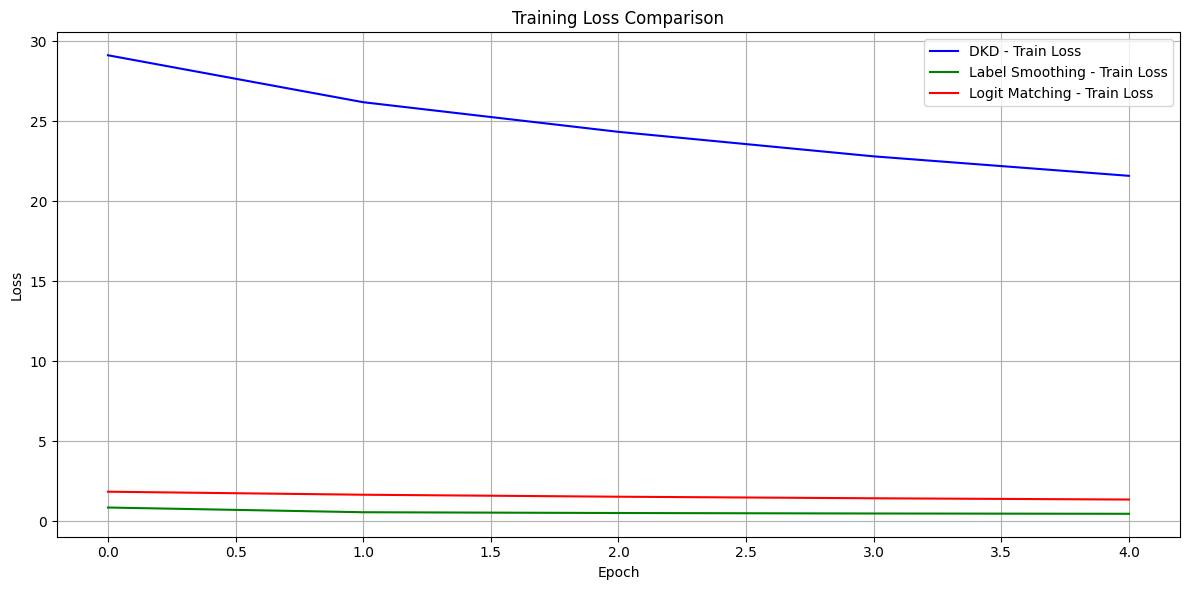

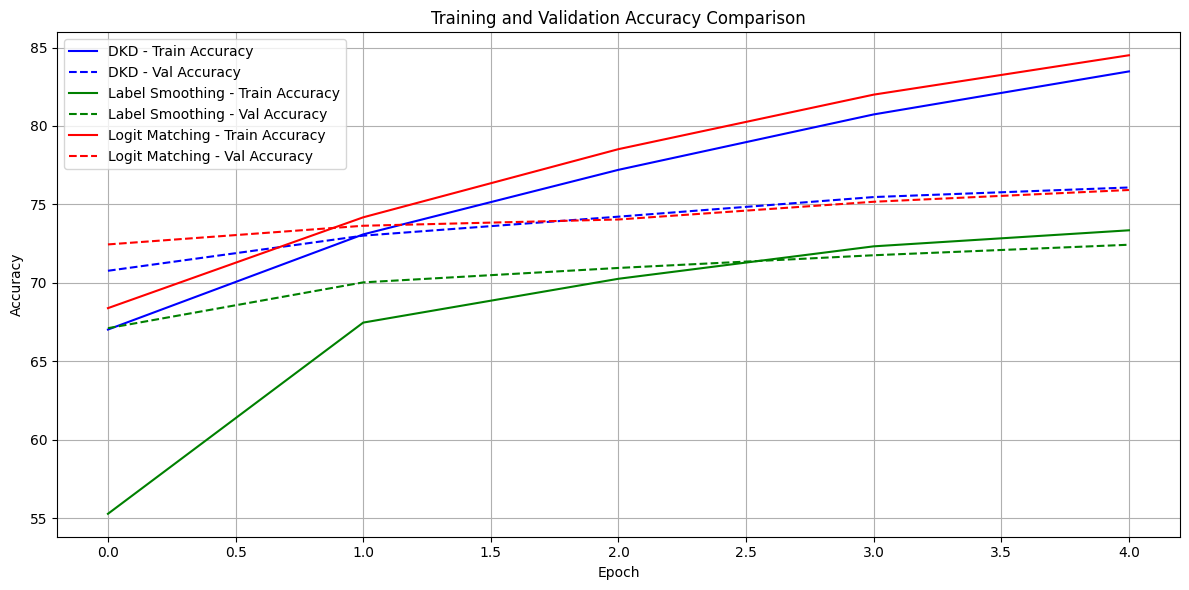

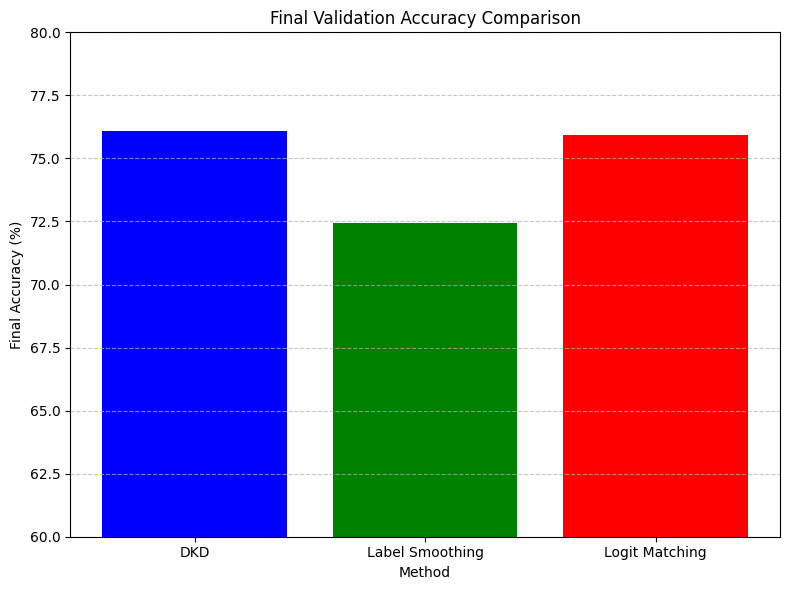

In [6]:
import matplotlib.pyplot as plt

# Plot only Training Loss
plt.figure(figsize=(12, 6))

# Plot DKD
plt.plot(dkd_df['Epoch'], dkd_df['Train Loss'], label='DKD - Train Loss', color='b', linestyle='solid')

# Plot Label Smoothing
plt.plot(labelsmoothing_df['Epoch'], labelsmoothing_df['Train Loss'], label='Label Smoothing - Train Loss', color='g', linestyle='solid')

# Plot Logit Matching
plt.plot(logitmatching_df['Epoch'], logitmatching_df['Train Loss'], label='Logit Matching - Train Loss', color='r', linestyle='solid')

plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Plot DKD
plt.plot(dkd_df['Epoch'], dkd_df['Train Accuracy'], label='DKD - Train Accuracy', color='b', linestyle='solid')
plt.plot(dkd_df['Epoch'], dkd_df['Validation Accuracy'], label='DKD - Val Accuracy', color='b', linestyle='dashed')

# Plot Label Smoothing
plt.plot(labelsmoothing_df['Epoch'], labelsmoothing_df['Train Accuracy'], label='Label Smoothing - Train Accuracy', color='g', linestyle='solid')
plt.plot(labelsmoothing_df['Epoch'], labelsmoothing_df['Validation Accuracy'], label='Label Smoothing - Val Accuracy', color='g', linestyle='dashed')

# Plot Logit Matching
plt.plot(logitmatching_df['Epoch'], logitmatching_df['Train Accuracy'], label='Logit Matching - Train Accuracy', color='r', linestyle='solid')
plt.plot(logitmatching_df['Epoch'], logitmatching_df['Validation Accuracy'], label='Logit Matching - Val Accuracy', color='r', linestyle='dashed')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

final_accuracies = {
    'DKD': dkd_df['Validation Accuracy'].iloc[-1],
    'Label Smoothing': labelsmoothing_df['Validation Accuracy'].iloc[-1],
    'Logit Matching': logitmatching_df['Validation Accuracy'].iloc[-1]
}

# Plot Bar Graph
plt.figure(figsize=(8, 6))
methods = list(final_accuracies.keys())
accuracies = list(final_accuracies.values())

plt.bar(methods, accuracies, color=['b', 'g', 'r'])
plt.title('Final Validation Accuracy Comparison')
plt.xlabel('Method')
plt.ylabel('Final Accuracy (%)')
plt.ylim([60, 80])  # Set y-axis range for better comparison
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
